# Derwael Isochrones with a y-Component

In [169]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "C:\\Users\\annem\\Documents\\Uni\\Master\\SS23\\Scientific Practice\\sbi_for_ice-anne_coupled_SIA")
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel,Matern
import pickle
from sbi.utils import get_density_thresholder, RestrictedPrior, BoxUniform,process_prior
from torch.distributions import MultivariateNormal


from utils import plotting_utils,Layer_Tracing_Sim as lts,custom_priors,modelling_utils
from utils.modelling_utils import regrid
from scipy.interpolate import LinearNDInterpolator


plt.rcParams.update({"figure.dpi": 200})
import SIA_yComponent as sia
import Derwael_Data_prep as d
from matplotlib import colors
from perpLines import get_perpLines
from netCDF4 import Dataset


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Initialization of Variables

In [3]:
nz = 40     	# Nr. of Gridpoints in z direction
A = 1.5*4.6e-24*60*60*24*365   # Pa^-3 a^-1  (Henry, 2022)   
g = 9.81        
rho = 910       
dx = 500         # size of grid in x dir.
dy = 500
nz = 30
dt = 0.0005
N = int(2e4)
n = 3           
smb = pd.read_csv("./Derwael_Data/smb.csv")
a_s = np.array(smb["smb"])
smb_x = np.array(smb["x"])


In [4]:
data = Dataset(".\\Derwael_Data\\DerwaelBCsGauss15.nc","r")
x_nc=np.array(data.variables["x"])
y_nc=np.array(data.variables["y"])
X,Y=np.meshgrid(x_nc,y_nc)
bed_RACMO = np.transpose(np.array(data.variables["bedrock"]))
thickness_RACMO = np.transpose(np.array(data.variables["thickness"]))
surface_RACMO = bed_RACMO+thickness_RACMO

data = Dataset(".\\Derwael_Data\\Derwael_SMB_dsdt_adjustment_n3E0.5Time50.nc","r")
x_smb=np.array(data.variables["x"])
y_smb=np.array(data.variables["y"])
X_smb,Y_smb=np.meshgrid(x_smb,y_smb)
smb_mat=np.transpose(np.array(data.variables["smb"]))

data_line = pd.read_csv(".\\Derwael_Data\\RadarSegment5.csv")
x_radar,y_radar,var = d.cut(np.array(data_line["psX"]),np.array(data_line["psY"]),[],947000,970000)
# y_radar= np.array(data_line["psY"])

par1, par2 = get_perpLines(x_radar,y_radar,dy)
x_radar=x_radar[:-1]
y_radar=y_radar[:-1]

# interpolate from the 3D Racmo data onto the 3 lines
surface = np.array([d.linecut(x_nc,y_nc,surface_RACMO,par1[0,:],par1[1,:]),d.linecut(x_nc,y_nc,surface_RACMO,x_radar,y_radar),d.linecut(x_nc,y_nc,surface_RACMO,par2[0,:],par2[1,:])])
bed = np.array([d.linecut(x_nc,y_nc,bed_RACMO,par1[0,:],par1[1,:]),d.linecut(x_nc,y_nc,bed_RACMO,x_radar,y_radar),d.linecut(x_nc,y_nc,bed_RACMO,par2[0,:],par2[1,:])])
smb_RACMO = np.array([d.linecut(x_smb,y_smb,smb_mat,par1[0,:],par1[1,:]),d.linecut(x_smb,y_smb,smb_mat,x_radar,y_radar),d.linecut(x_smb,y_smb,smb_mat,par2[0,:],par2[1,:])])



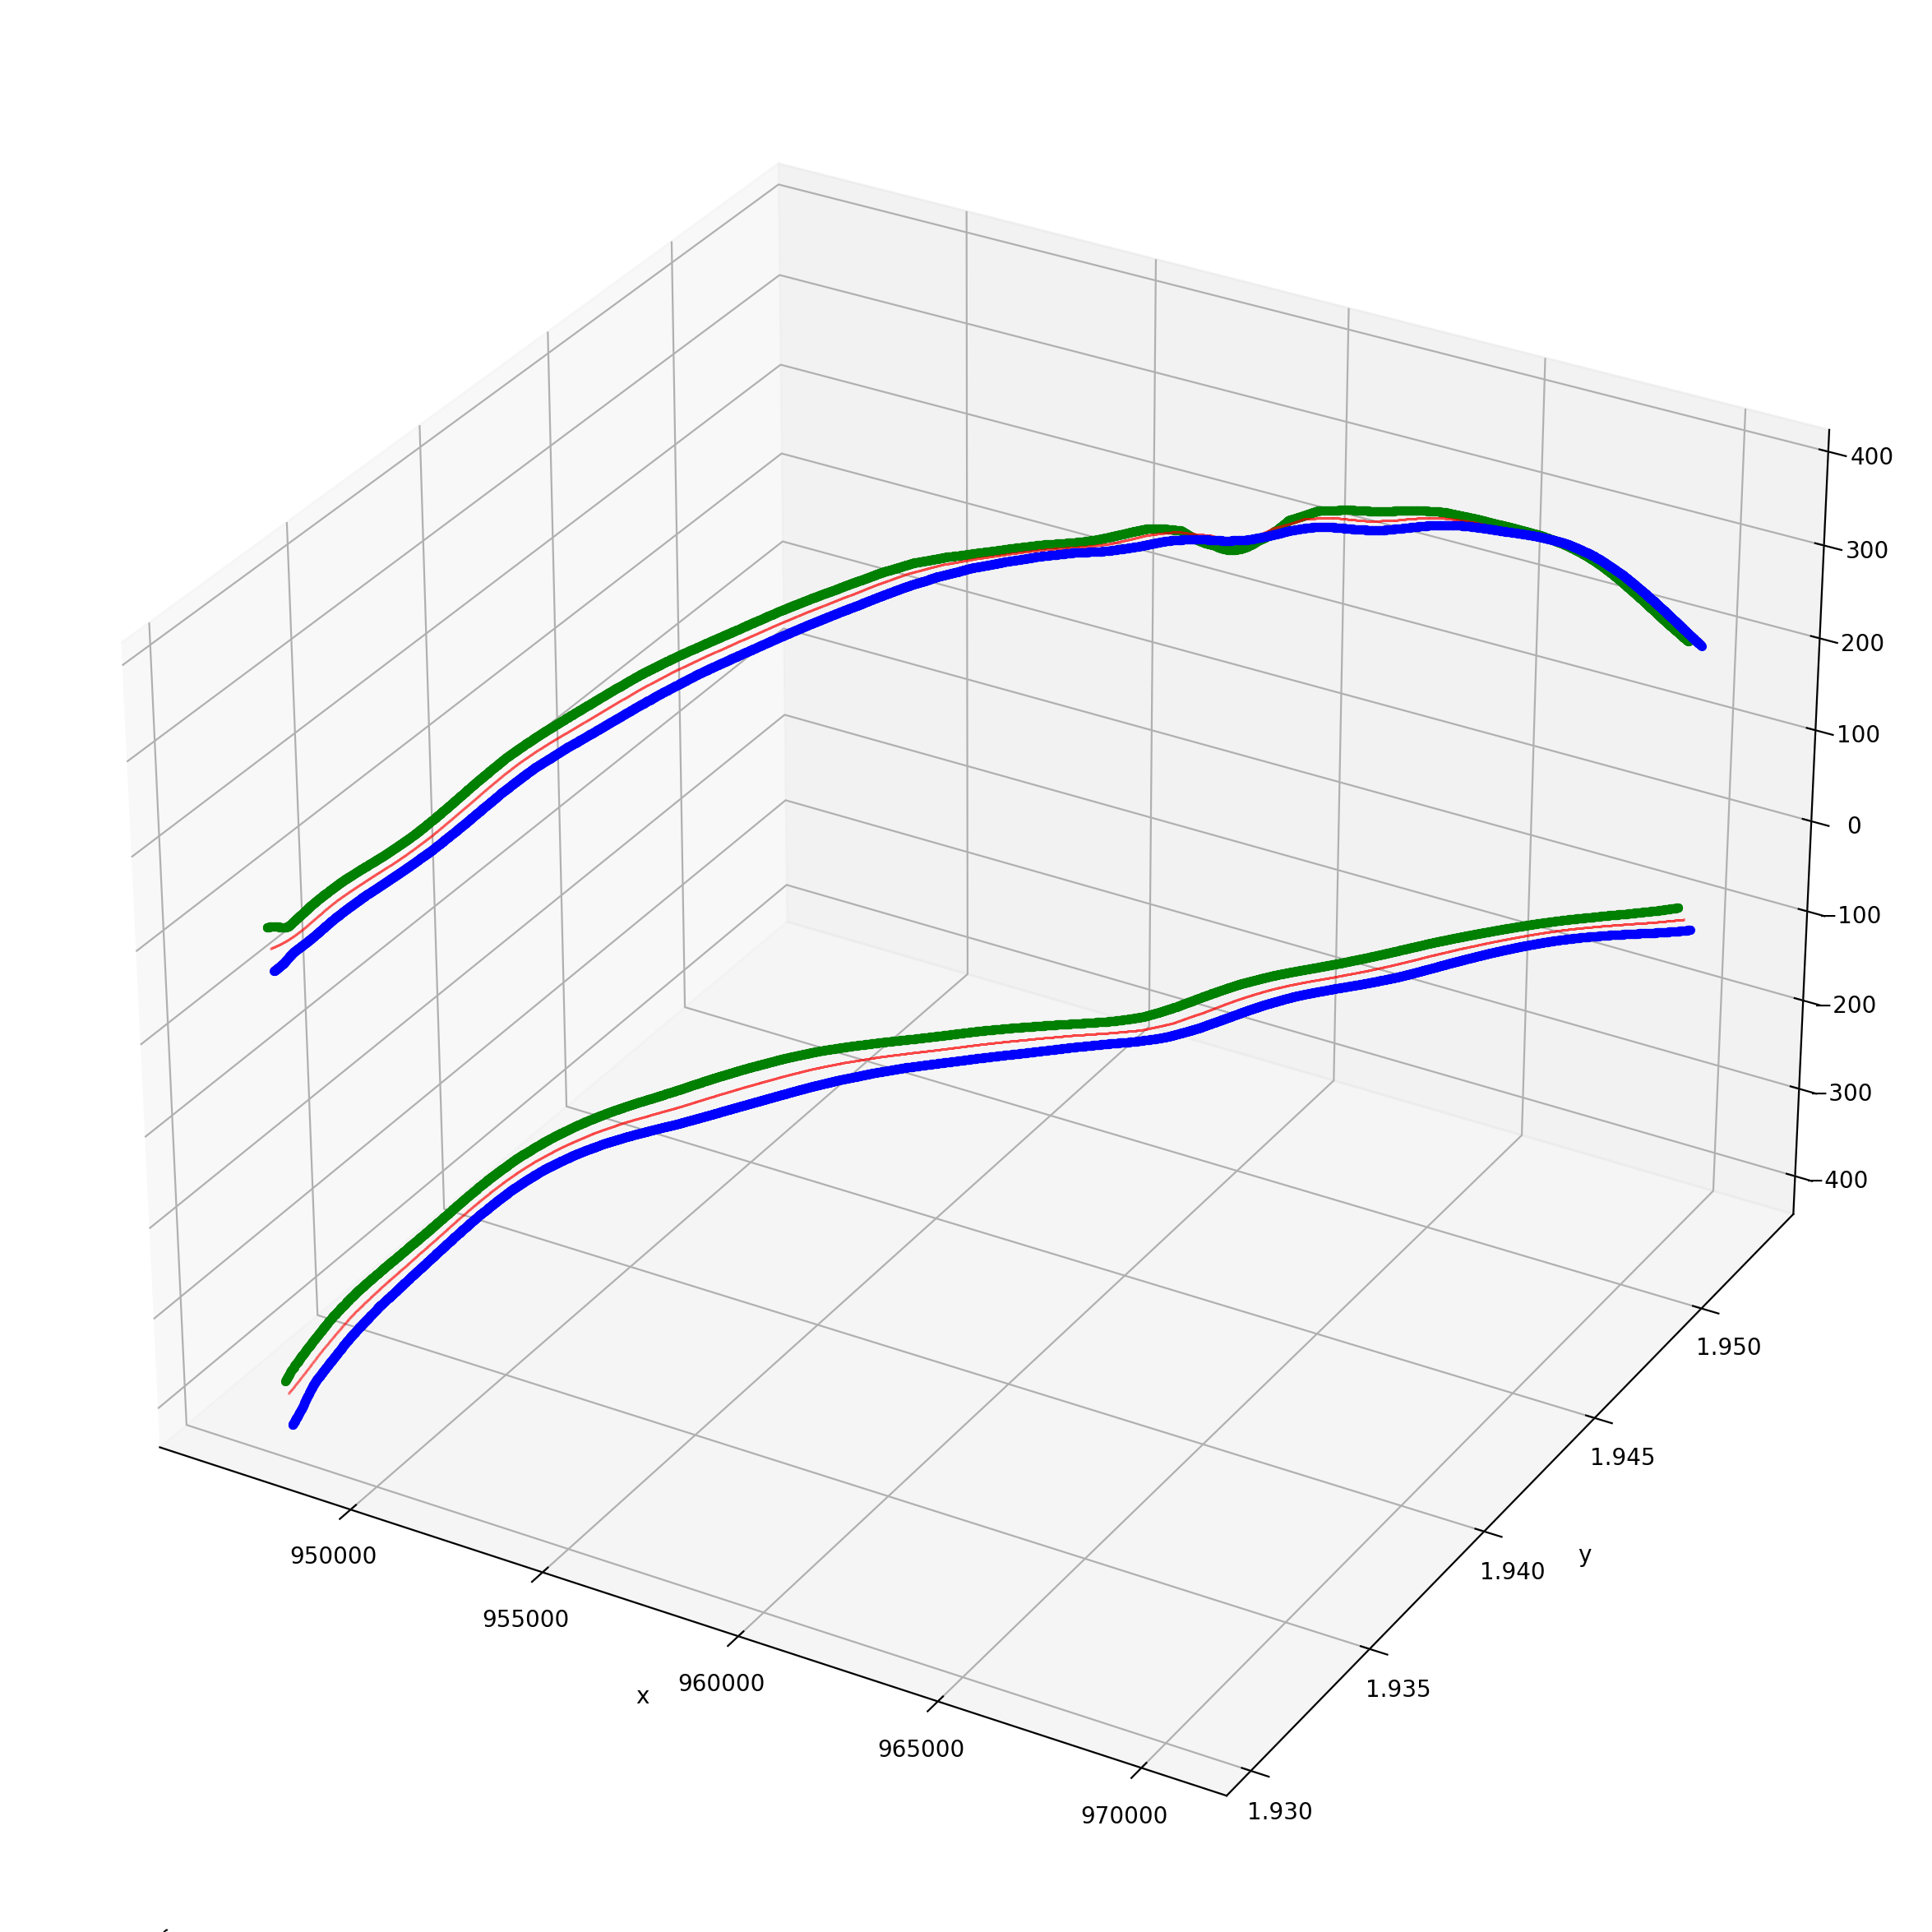

In [5]:

fig = plt.figure(figsize=(20,15))
ax = plt.axes(projection='3d')
ax.set(xlabel="x",ylabel="y")

ax.plot3D(par1[0,:],par1[1,:],surface[0,:],".g")
ax.plot3D(x_radar,y_radar,surface[1,:],".r",markersize=0.1)
ax.plot3D(par2[0,:],par2[1,:],surface[2,:],".b")

ax.plot3D(par1[0,:],par1[1,:],bed[0,:],".g")
ax.plot3D(x_radar,y_radar,bed[1,:],".r",markersize=0.1)
ax.plot3D(par2[0,:],par2[1,:],bed[2,:],".b")

ax.view_init(30, -60)

In [6]:
x_proj,x_zero = d.x_axis_projection(x_radar,y_radar)
x_grid = np.arange(min(x_zero),max(x_zero),dx)
surface_grid = np.array([np.interp(x_grid,x_zero,surface[0,:]),np.interp(x_grid,x_zero,surface[1,:]),np.interp(x_grid,x_zero,surface[2,:])])
bed_grid = np.array([np.interp(x_grid,x_zero,bed[0,:]),np.interp(x_grid,x_zero,bed[1,:]),np.interp(x_grid,x_zero,bed[2,:])])
smb = np.array([np.interp(x_grid,x_zero,smb_RACMO[0,:]),np.interp(x_grid,x_zero,smb_RACMO[1,:]),np.interp(x_grid,x_zero,smb_RACMO[2,:])])

# fig = plt.figure(figsize=(20,15))
# ax = plt.axes(projection='3d')
# ax.set(xlabel="x",ylabel="y")

# ax.plot3D(x_grid,-500*np.ones(np.shape(x_grid)),smb[0,:],".g")
# ax.plot3D(x_grid,0*np.ones(np.shape(x_grid)),smb[1,:],".r",markersize=0.1)
# ax.plot3D(x_grid,500*np.ones(np.shape(x_grid)),smb[2,:],".b")

# ax.view_init(20, 60)

In [7]:
devide_old = (np.argmax(surface_grid[1,:]),max(surface_grid[1,:]))
boundary=np.array(((1,sum(smb[1,:devide_old[0]]*dx)),(1,-sum(smb[1,devide_old[0]:]*dx))))

[Text(0.5, 0, '$x\\,[m]$'), Text(0, 0.5, '$z\\,[m]$')]

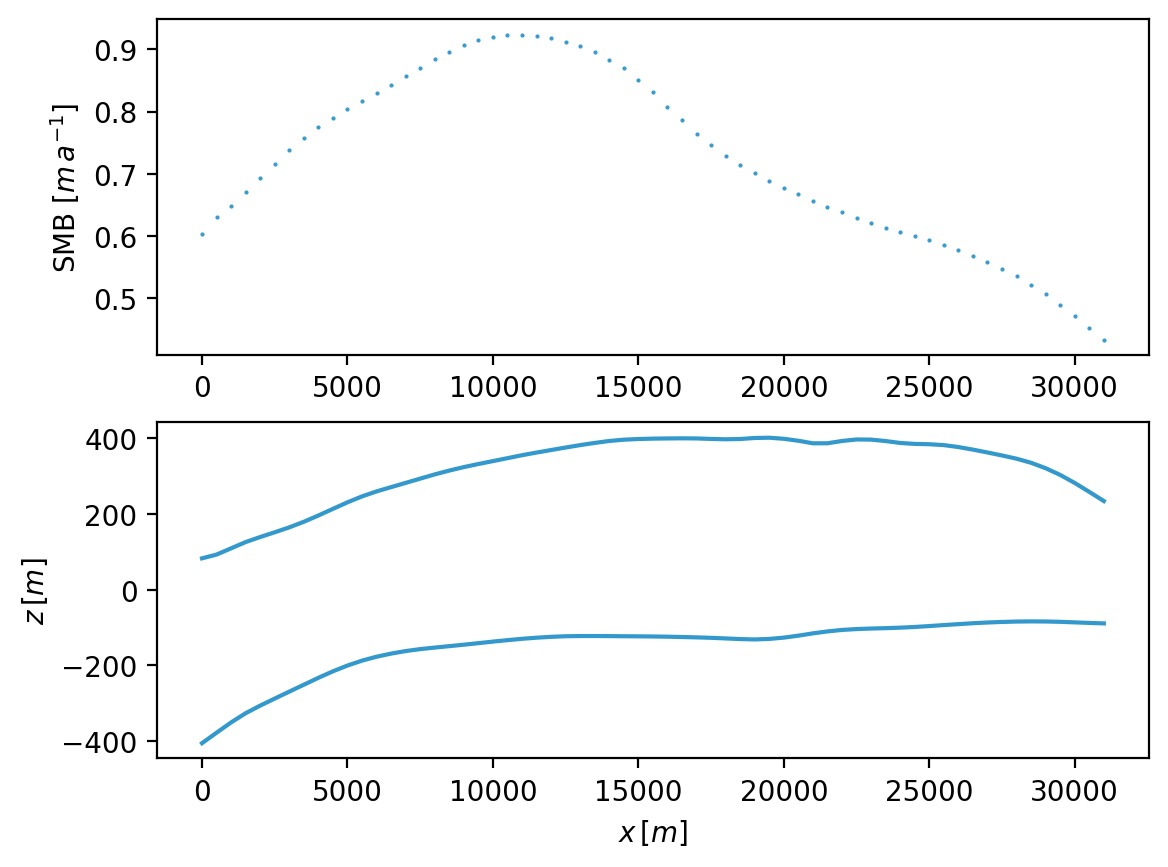

In [8]:
fig,ax=plt.subplots(2)
ax[0].plot(x_grid,smb[1,:],".",color=(0.2,0.6,0.8), markersize = 1)
ax[0].set(ylabel=r"SMB $[m\,a^{-1}]$")
ax[1].plot(x_grid,surface_grid[1,:],"-",color=(0.2,0.6,0.8))
ax[1].plot(x_grid,bed_grid[1,:],"-",color=(0.2,0.6,0.8))
ax[1].set(xlabel=r"$x\,[m]$",ylabel=r"$z\,[m]$")


#### Transient Model

In [9]:
sol_h, sol_vx, sol_vy, Zgrid,timesteps=sia.solution(bed_grid, surface_grid, smb, dx, dy, nz, dt, N, n, rho, A, g)
print("time taken to reach steady state: "+str(timesteps*dt))

time taken to reach steady state: 10.0


In [10]:
print(timesteps)

20000


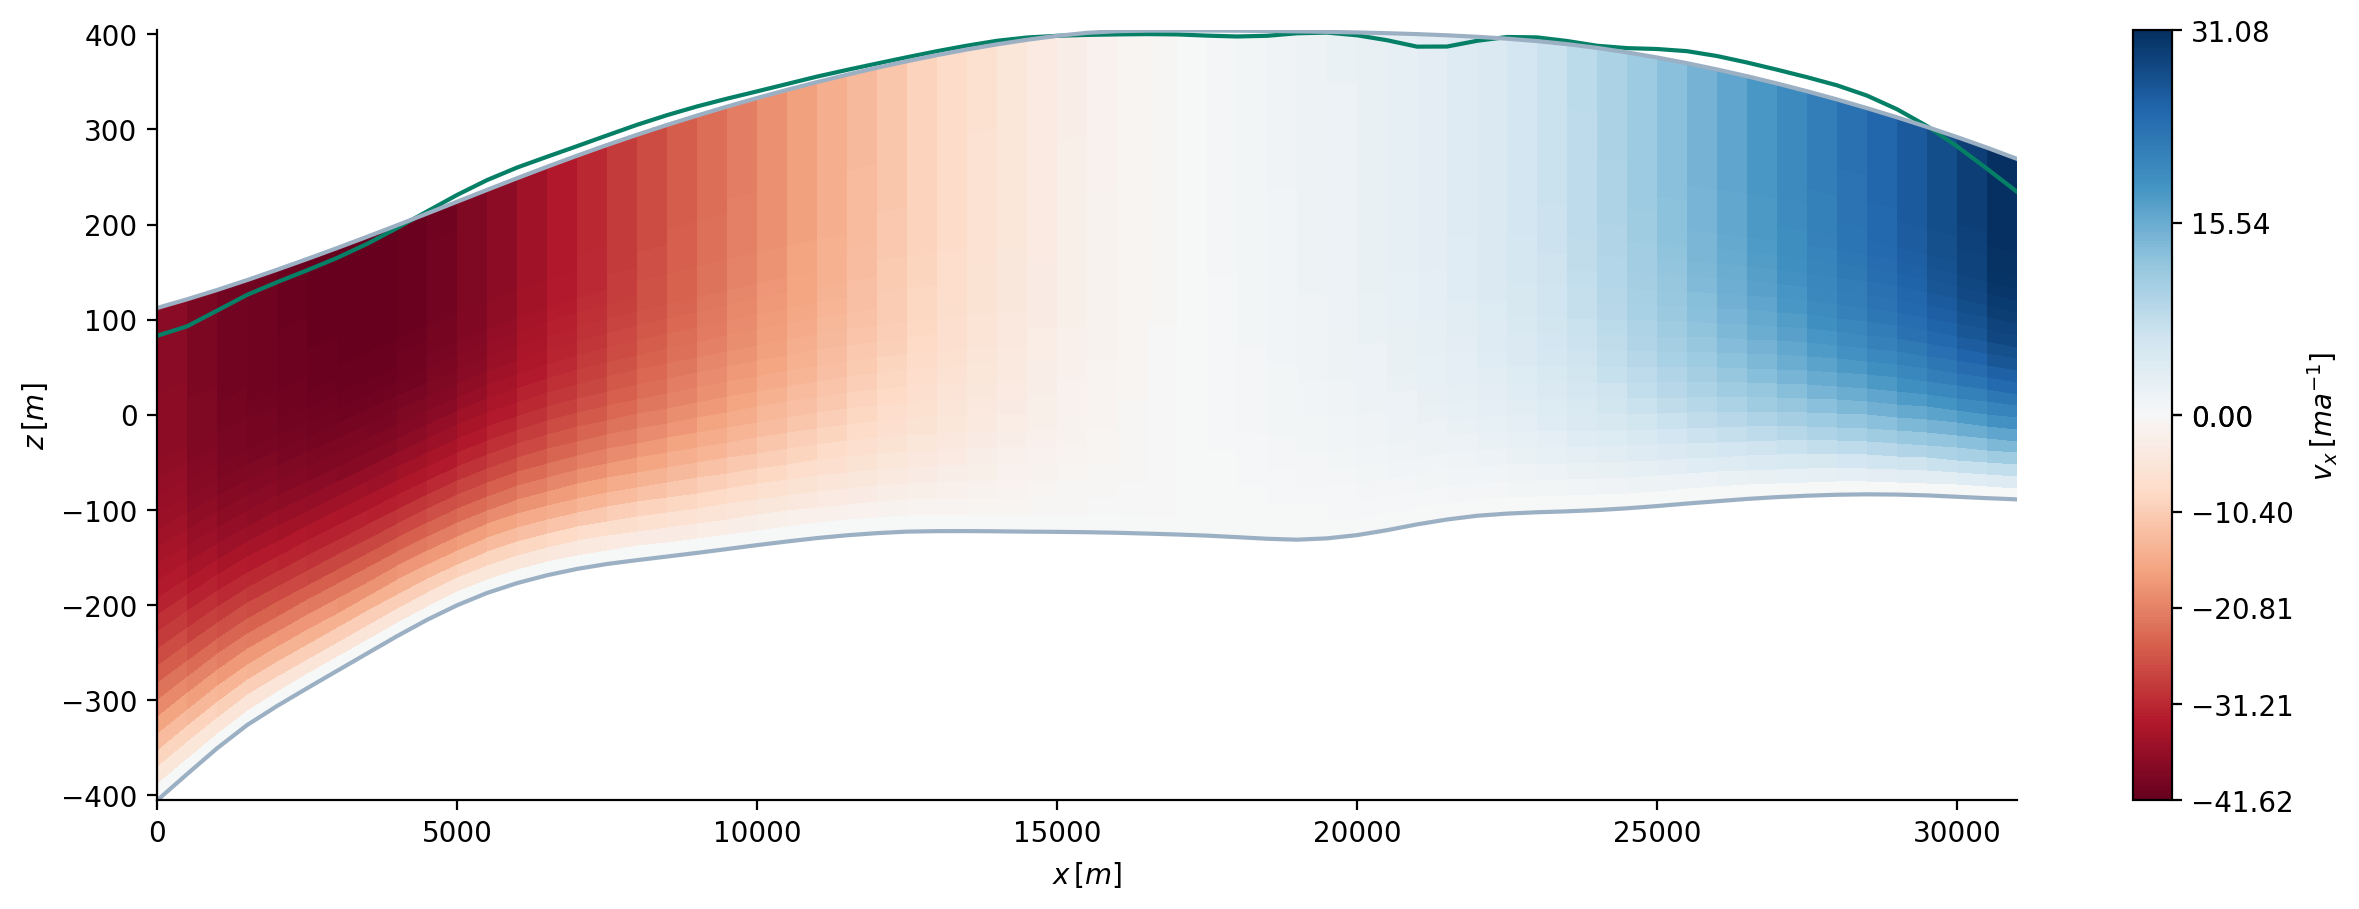

In [13]:
for i in [timesteps]:
    fig,ax=plt.subplots(figsize=(15,5))
    X=np.meshgrid(x_grid)
    Z_new = Zgrid[i][:,:]
    divnorm=colors.TwoSlopeNorm(vmin=np.matrix.min(np.matrix(sol_vx[i])), vcenter=0., vmax=np.matrix.max(np.matrix(sol_vx[i])))# colors.TwoSlopeNorm(vmin=-162.2, vcenter=0., vmax=144.2)
    cp=plt.pcolormesh(X,Z_new,sol_vx[i][:-1,:],cmap="RdBu",norm=divnorm)
    plt.colorbar(cp,label=r"$v_x\,[ma^{-1}]$",ticks=np.append(np.append(np.linspace(np.matrix.min(np.matrix(sol_vx[i])),0,5),0),np.linspace(0,np.matrix.max(np.matrix(sol_vx[i])),3)[1:]))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(xlabel=r"$x\,[m]$",ylabel=r"$z\,[m]$")
    plt.plot(x_grid,surface_grid[1,:],"-",color=(0.02,0.5,0.4),label="old surface")
    #plt.legend(framealpha=0.0)
    # for i in np.arange(0,len(geom.dsum_iso[0,0,:])):
    #     plt.plot(x_grid,iso_grid[i],"-k", linewidth=.7,alpha=0.5)
    #     if np.round(geom.age_iso[i]) in [100.0,200.0,500.0,1000.0,1500, 2000.0, 8000.0]:
    #         plt.text(x_grid[-1]+200,iso_grid[i][-1]-10,np.round(geom.age_iso[i]),color=(.96,.777,.19))#(0.7,0.1,0.3))
    #         plt.plot(x_grid,iso_grid[i],"-",color=(.96,.777,.19))
    #         #plt.plot(x_grid,iso_grid[i],"--",color=(0.7,0.1,0.3))
    plt.plot(x_grid,bed_grid[1,:],"-",color=(156/255,176/255,196/255),markersize=1,label="bed")
    plt.plot(x_grid,sol_h[i][1,:],"-",color=(156/255,176/255,196/255),markersize=1,label="surface")
plt.savefig(".\\Test_Results\\Derwael\\Assumption_Vx.pdf")

-25.40604830599239
11.762328748618891


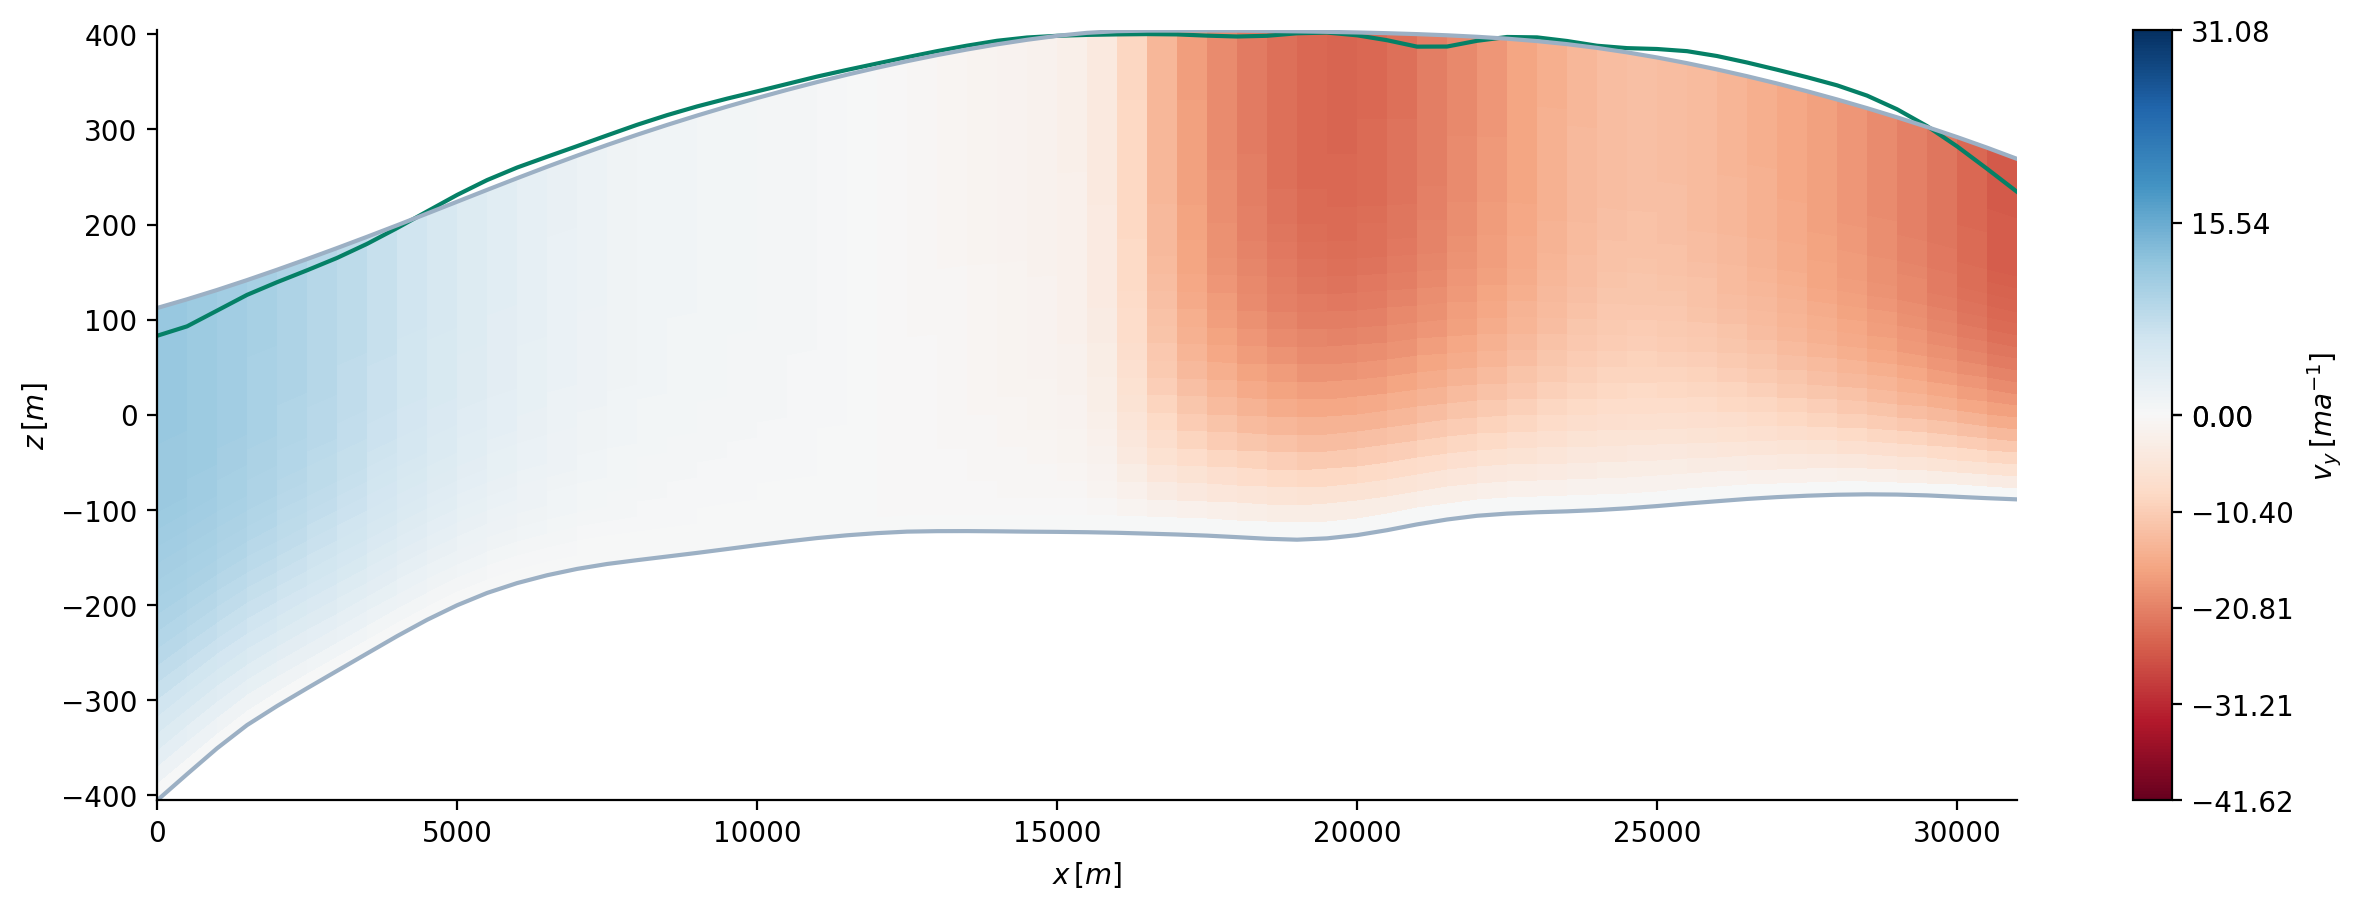

In [14]:
for i in [timesteps]:
    fig,ax=plt.subplots(figsize=(15,5))
    X=np.meshgrid(x_grid)
    Z_new = Zgrid[i][:,:]
    divnorm=colors.TwoSlopeNorm(vmin=np.matrix.min(np.matrix(sol_vx[i])), vcenter=0., vmax=np.matrix.max(np.matrix(sol_vx[i])))# colors.TwoSlopeNorm(vmin=-162.2, vcenter=0., vmax=144.2)
    cp=plt.pcolormesh(X,Z_new,sol_vy[i][:-1,:],cmap="RdBu",norm=divnorm)
    plt.colorbar(cp,label=r"$v_y\,[ma^{-1}]$",ticks=np.append(np.append(np.linspace(np.matrix.min(np.matrix(sol_vx[i])),0,5),0),np.linspace(0,np.matrix.max(np.matrix(sol_vx[i])),3)[1:]))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(xlabel=r"$x\,[m]$",ylabel=r"$z\,[m]$")
    plt.plot(x_grid,surface_grid[1,:],"-",color=(0.02,0.5,0.4),label="old surface")
    #plt.legend(framealpha=0.0)
    # for i in np.arange(0,len(geom.dsum_iso[0,0,:])):
    #     plt.plot(x_grid,iso_grid[i],"-k", linewidth=.7,alpha=0.5)
    #     if np.round(geom.age_iso[i]) in [100.0,200.0,500.0,1000.0,1500, 2000.0, 8000.0]:
    #         plt.text(x_grid[-1]+200,iso_grid[i][-1]-10,np.round(geom.age_iso[i]),color=(.96,.777,.19))#(0.7,0.1,0.3))
    #         plt.plot(x_grid,iso_grid[i],"-",color=(.96,.777,.19))
    #         #plt.plot(x_grid,iso_grid[i],"--",color=(0.7,0.1,0.3))
    plt.plot(x_grid,bed_grid[1,:],"-",color=(156/255,176/255,196/255),markersize=1,label="bed")
    plt.plot(x_grid,sol_h[i][1,:],"-",color=(156/255,176/255,196/255),markersize=1,label="surface")
plt.savefig(".\\Test_Results\\Derwael\\Assumption_Vy.pdf")
print(np.matrix.min(np.matrix(sol_vy[i])))
print(np.matrix.max(np.matrix(sol_vy[i])))

#### save last timestep for isochrone calculations

In [15]:
data = {"x_coord":x_grid[:-1],"velocity":sol_vx[-1][1,:],"dQdy":np.zeros(np.shape(x_grid[:-1])),"dQdx":np.zeros(np.shape(x_grid[:-1])),"base":bed_grid[1,:-1],"surface":sol_h[-1][1,:-1],"smb":smb[1,:-1]}
d=pd.DataFrame(data=data)
d.to_csv(".\\Test_Results\\Derwael\\results.csv")

## Age solver

In [82]:
Z = Zgrid[-1][:,:-1]
vx = sol_vx[-1]
vy = sol_vy[-1]
x = np.tile(x_grid[:-1],(nz,1))

Z = Z.flatten()
X = x.flatten()
vx = vx.flatten()

vx_interp = LinearNDInterpolator(list(zip(X,Z)),vx)
print(vx_interp(x_grid[:-1],Zgrid[-1][-1,:-1]))

[-37.45180135 -39.12047156 -40.20946402 -40.56211481 -41.00208492
 -41.37531995 -41.59382384 -41.61954003 -41.21083381 -40.32205607
 -38.99899077 -37.30180765 -35.42822787 -33.44754396 -31.35755329
 -29.22370394 -27.17875729 -25.15556805 -23.16518764 -21.17726517
 -19.18025726 -17.21490464 -15.26128365 -13.35691728 -11.5166315
  -9.73527422  -8.07065141  -6.51421227  -5.07667942  -3.76916482
  -2.60960084  -1.64711862  -0.93494222  -0.36874756   0.10943304
   0.52198617   0.88796668   1.22909683   1.57581573   1.94305043
   2.35537828   2.83268238   3.38244635   4.04156749   4.82818455
   5.7868783    6.92743729   8.26238037   9.75048135  11.3474707
  13.01391822  14.70054884  16.42160709  18.12221411  19.80850979
  21.47773455  23.09295283  24.65091469  26.1671982   27.65427256
  29.26817051  31.08293161]


In [179]:
data_file = ".\\Test_Results\\Derwael\\results.csv"

# name = "Synthetic"
# data_file = "../../coords/" + name + "/setup_files/flowtube_tmb_final.csv"
#data_file = "../../coords/" + name + "/setup_files/flowtube_short.csv"

df = pd.read_csv(data_file)
xmb = df["x_coord"].to_numpy() #x - coordinates of domain
tmb = smb[1,:-1] #total mass balance
Lx = xmb.max() - xmb.min()
dt = 0.1
print(np.shape(xmb))
nx_iso             = len(bed_grid[1,:-1]) # Number of points in the x-direction
ny_iso             = 1 # Number of points in the y-direction
geom = lts.Geom(nx_iso=nx_iso,ny_iso=ny_iso,nz=nz,A=A,rho=rho,g=g,n=n,Z=Zgrid[-1][:,:-1],vx=sol_vx[-1],vy=sol_vy[-1]) #This will be the main object we interact with
# geom = lts.Geom(nx_iso=nx_iso,ny_iso=ny_iso,A=A,rho=rho,g=g,n=n) #This will be the main object we interact with
smb_regrid,bmb_regrid = lts.init_geom_from_fname(geom,data_file,smb=tmb)

(62,)


In [180]:
n_surface_phase1 = 1000 #number of iterations per addition of surface layer
sim_time1 = 2000
sched1 = lts.Scheduele(sim_time1,dt,n_surface_phase1)
print(sched1.total_iterations)


20000


In [181]:
#Now simulate
geom.initialize_layers(sched1,1)
lts.sim(geom,smb_regrid,bmb_regrid,sched1)

[[-405.27139461 -377.63259305 -350.46569106 ...  -84.6188542
   -86.08304819  -87.54578142]
 [-387.42218586 -360.42082253 -333.85316283 ...  -71.26476446
   -73.04485337  -74.84185361]
 [-369.57297712 -343.20905202 -317.2406346  ...  -57.91067472
   -60.00665856  -62.13792579]
 ...
 [  76.65724144   87.08521082   98.07257116 ...  275.94156876
   265.94821179  255.46026958]
 [  94.50645018  104.29698134  114.68509939 ...  289.2956585
   278.98640661  268.1641974 ]
 [ 112.35565892  121.50875185  131.29762762 ...  302.64974824
   292.02460142  280.86812521]]


KeyboardInterrupt: 

Text(0, 0.5, 'age')

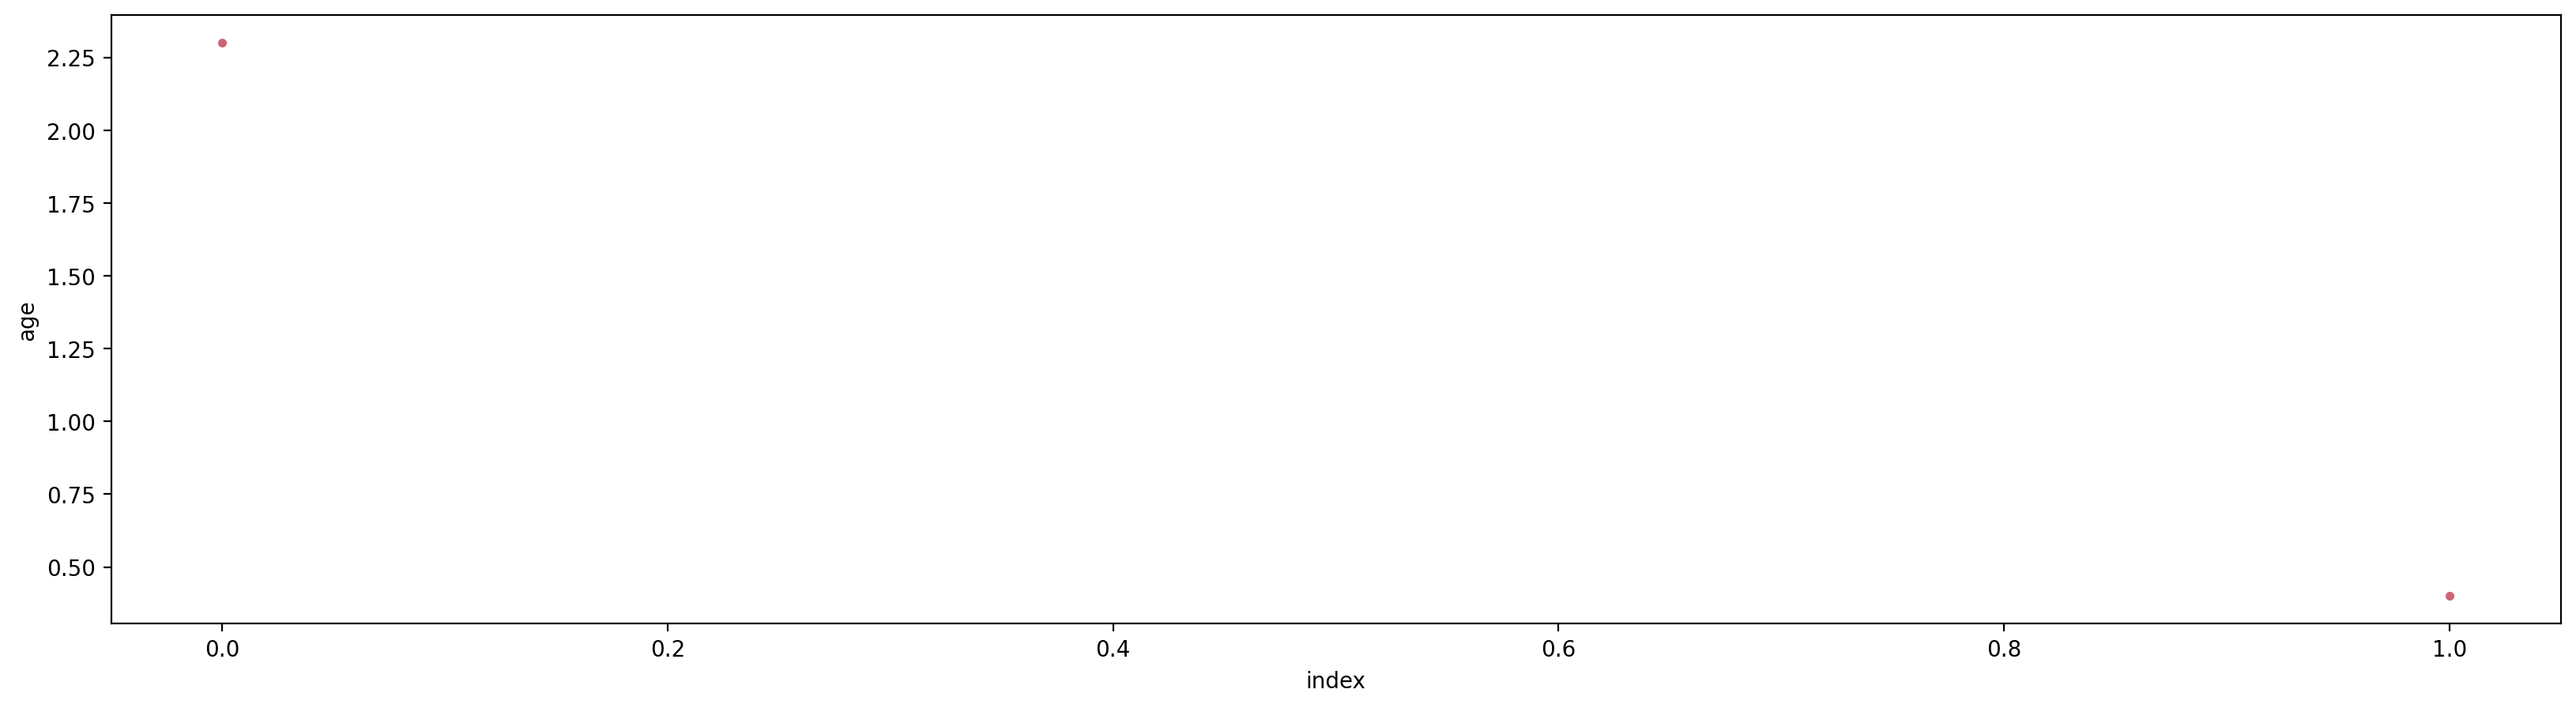

In [176]:
isochrones = geom.dsum_iso[:,0,:]
iso_grid = [bed_grid[1,:]+np.interp(x_grid,geom.x,isochrones[:,i]) for i in range(np.shape(isochrones)[1])]
age = geom.age_iso[:]
fig,ax=plt.subplots(figsize=(20,5))
plt.plot(range(0,len(age)),age[0:],".")
plt.xlabel("index")
plt.ylabel("age")

In [177]:
plot_indices =np.arange(0,len(geom.dsum_iso[0,0,:]),1)
data=pd.read_csv(".\\Test_Results\\Derwael_surface-bed\\results.csv")
for j in plot_indices:
    data[f"isochrones_{j}"]=np.interp(data["x_coord"],geom.x,geom.dsum_iso[:,0,j])
data.to_csv(".\\Test_Results\\Derwael_surface-bed\\results.csv")

(1, 62)


C:\Users\annem\AppData\Local\Temp\ipykernel_20192\324462546.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cp=plt.pcolormesh(X,Z_new,sol_vx[-1],cmap="RdBu",norm=divnorm)


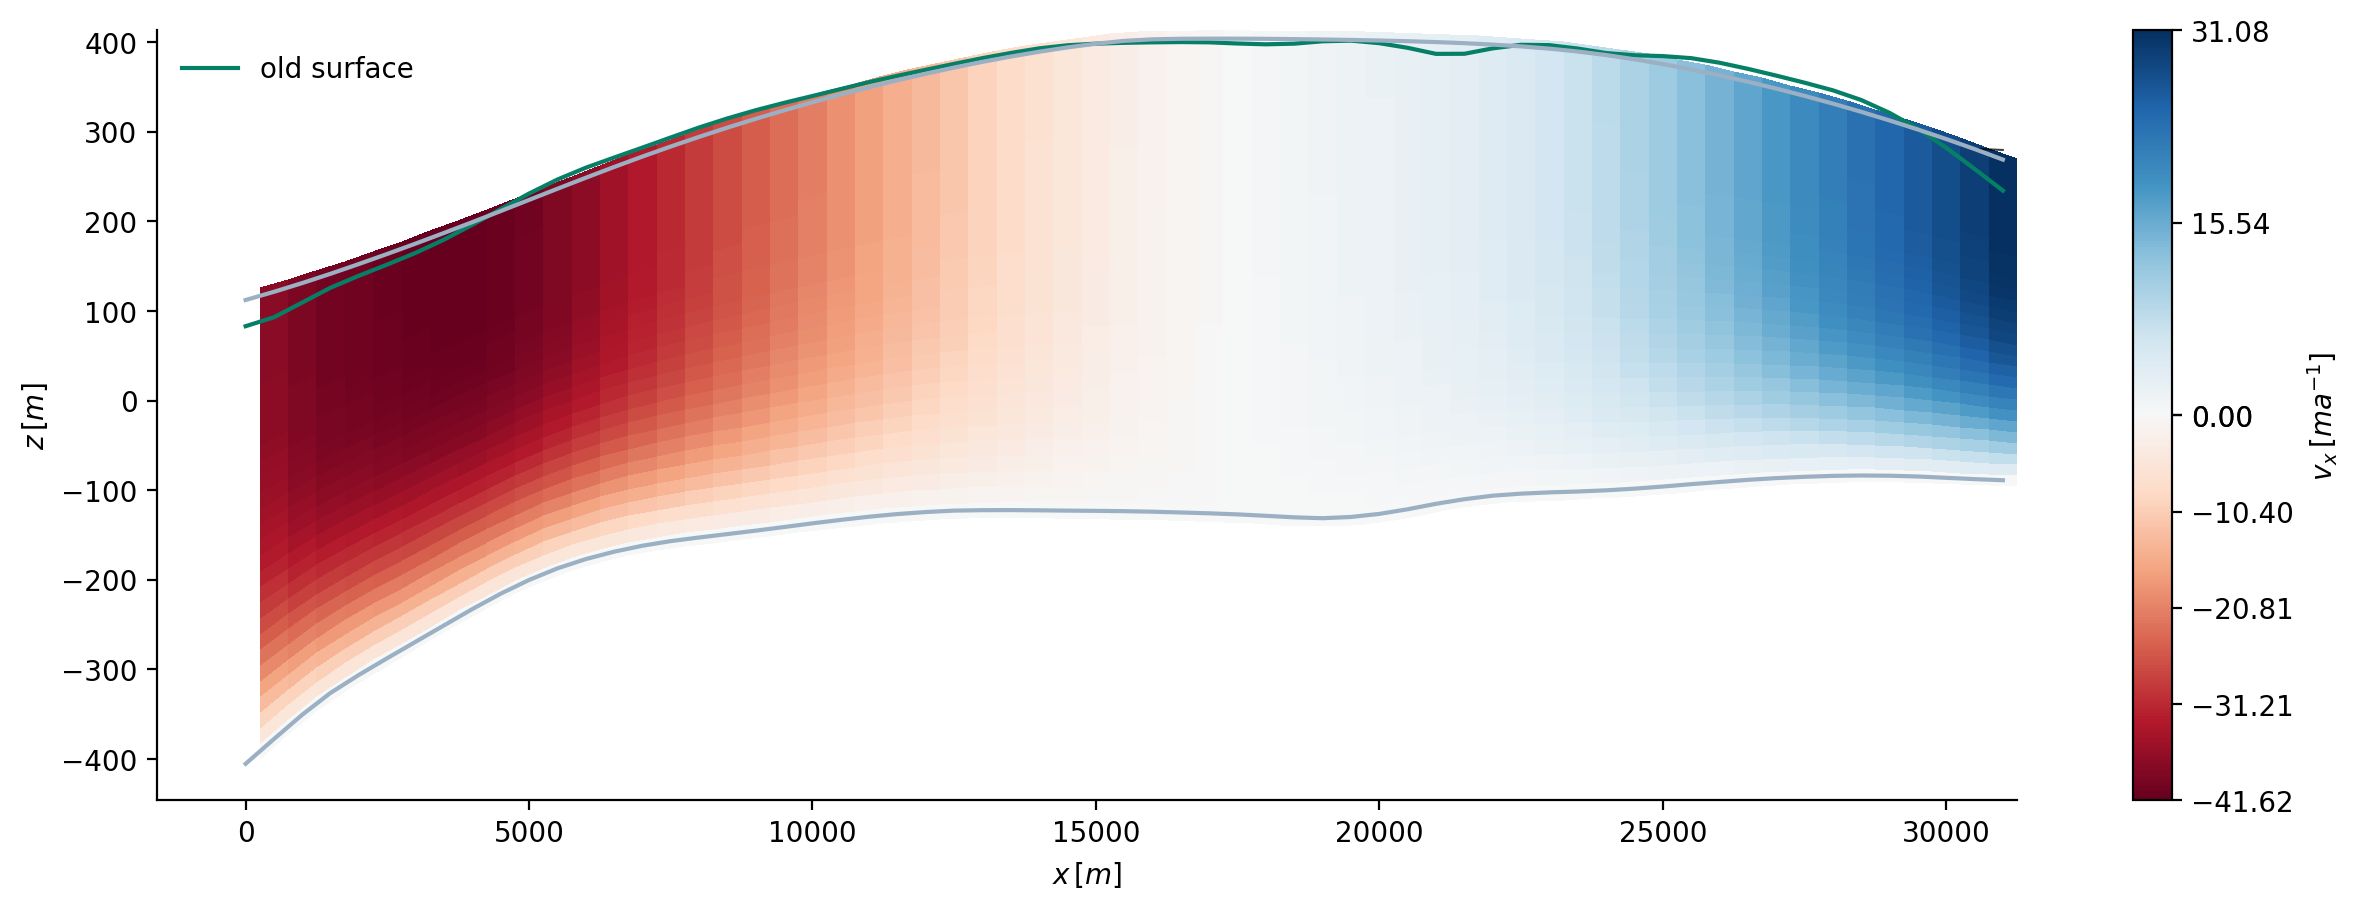

In [178]:
fig,ax=plt.subplots(figsize=(15,5))
X=np.meshgrid(x_grid[1:])
print(np.shape(X))
Z_new = [Zgrid[-1][j,1:] for j in range(len(Zgrid[-1]))]
divnorm=colors.TwoSlopeNorm(vmin=np.matrix.min(np.matrix(sol_vx[-1])), vcenter=0., vmax=np.matrix.max(np.matrix(sol_vx[-1])))
cp=plt.pcolormesh(X,Z_new,sol_vx[-1],cmap="RdBu",norm=divnorm)
plt.colorbar(cp,label=r"$v_x\,[ma^{-1}]$",ticks=np.append(np.append(np.linspace(np.matrix.min(np.matrix(sol_vx[-1])),0,5),0),np.linspace(0,np.matrix.max(np.matrix(sol_vx[-1])),3)[1:]))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set(xlabel=r"$x\,[m]$",ylabel=r"$z\,[m]$")
plt.plot(x_grid,surface_grid[1,:],"-",color=(0.02,0.5,0.4),label="old surface")
plt.legend(framealpha=0.0)
for i in np.arange(0,len(geom.dsum_iso[0,0,:])):
    plt.plot(x_grid,iso_grid[i],"-k", linewidth=.7,alpha=0.5)
    if np.round(geom.age_iso[i]) in [100.0,200.0,500.0,1000.0,1500, 2000.0, 8000.0]:
        plt.text(x_grid[-1]+200,iso_grid[i][-1]-10,np.round(geom.age_iso[i]),color=(.96,.777,.19))#(0.7,0.1,0.3))
        plt.plot(x_grid,iso_grid[i],"-",color=(.96,.777,.19))
      #  plt.plot(x_grid,iso_grid[i],"--",color=(0.7,0.1,0.3))
plt.plot(x_grid,bed_grid[1,:],"-",color=(156/255,176/255,196/255),markersize=1,label="bed")
plt.plot(x_grid,sol_h[-1][1,:],"-",color=(156/255,176/255,196/255),markersize=1,label="surface")
# plt.savefig(".\\Test_Results\\Derwael\\Assumption_noVy.pdf")